<a href="https://colab.research.google.com/github/jfongjw/CSCI_135_CPP/blob/master/Participant_Key.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code we will be using has been adapted from François Chollet's code that can be found [here](https://keras.io/examples/nlp/lstm_seq2seq/).
For those who would like to go a little deeper into the code than we will be getting, he has his own comments throughout that might interest you.

Go to this link: https://bit.ly/csc_nmt_participant and save your own copy.

In Google Colab, you just need to import the packages below because Colab has them pre-installed.

If running locally on your own computer, make sure to have numpy and tensorflow downloaded.

Keras simplifies the code required for deep neural networks. For example, implementing layers and activation functions. Numpy is for arrays, and tensorflow is for a general ML package.

In [ ]:
# STEP 1
#import numpy as np
#import tensorflow as tf
#from tensorflow import keras

Here, we are downloading data of common Italian-English phrases. Next, the code is unzipping the file.

In [ ]:
# STEP 2
#!!curl -O http://www.manythings.org/anki/ita-eng.zip


In [ ]:
# STEP 3
# Path to the data txt file on disk.
data_path = 

We need to prepare the data we just downloaded so we can use it for training. First, I create empty lists for the English sentences and Italian sentences. 
Next, we create a set just for the tokens (you can think of these as letters and symbols) for the English sentences and the Italian sentences. We will later use the sets to index each token.

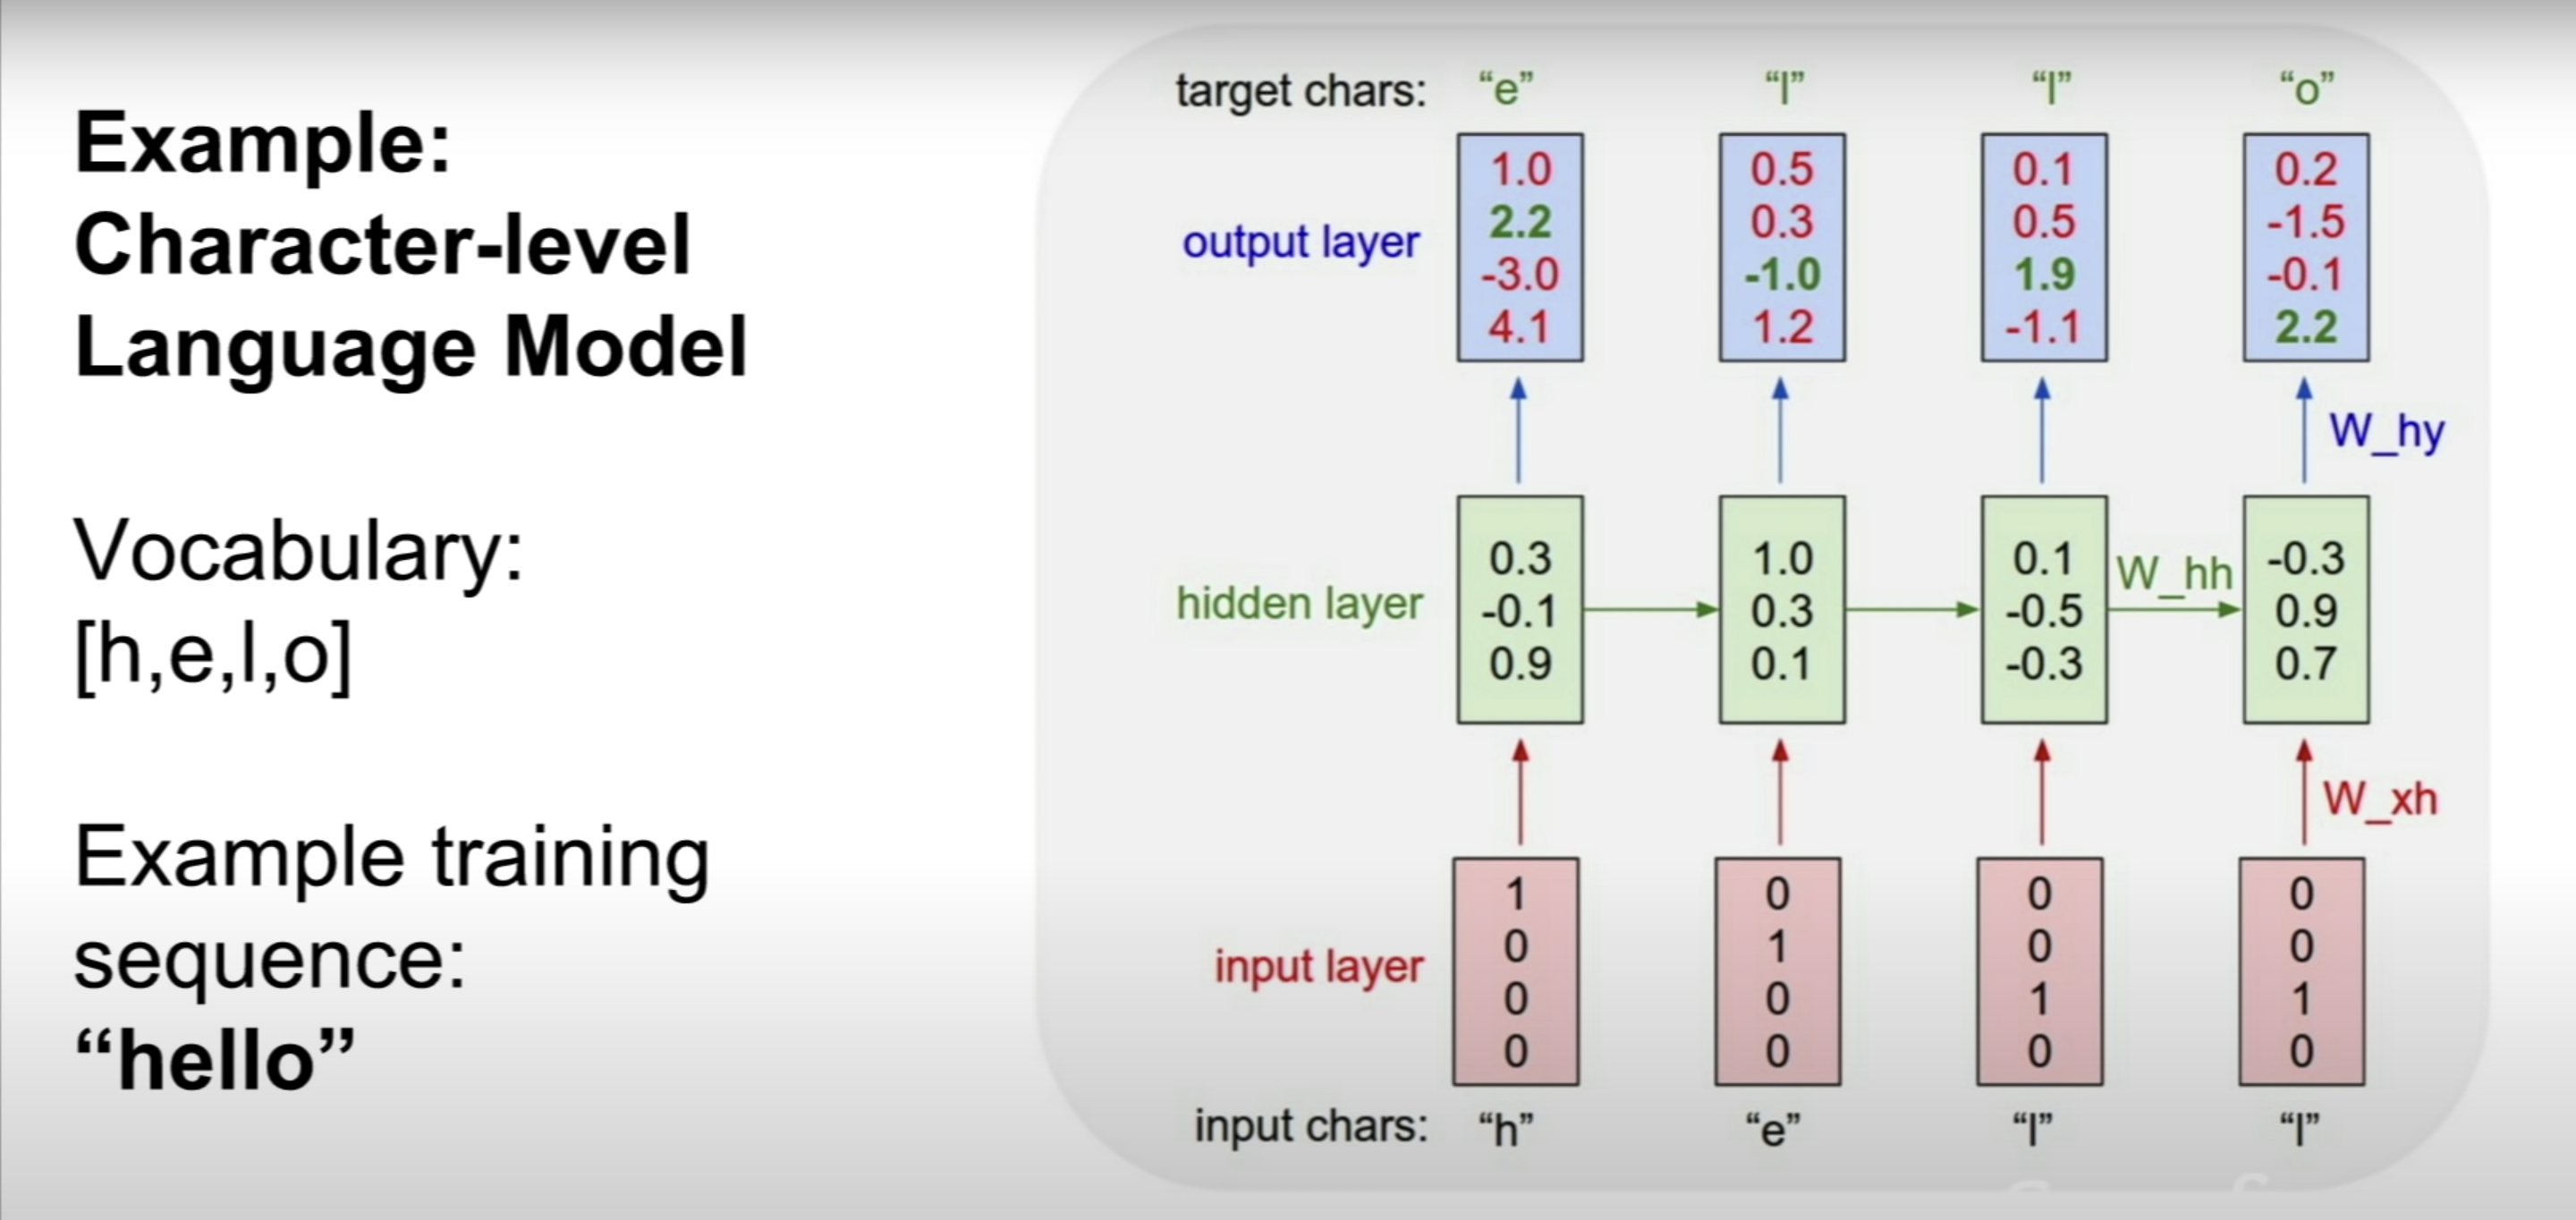

In [ ]:
# STEP 4
input_texts =  
target_texts = 
input_characters = set
target_characters = set

with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n") # It is giving us the text line by line.

In [ ]:
lines

In [ ]:
# STEP 5
num_samples =   # Number of samples to train on.

The code below is splitting the lines into input text (English) and target text (Italian). We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.

Next, we add each English line to the set input_texts, initialized above, and each Italian line to target_texts.

We then go one step further and look at the characters next. Since sets cannot have repeating elements, we only add them if they were not previously present, hence the for loop.

In [ ]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")

# STEP 6
   # target_text = "\t" + target_text + "\n"

    input_texts.append(input_text)
    target_texts.append(target_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

Here, we are sorting the tokens as a means to prepare them for indexing. The purpose of indexing is to give the tokens we have a way to be referred to as numbers so we can apply the algorithm to them. 

The lines that follow tell us about the size of the sets we are dealing with. Notice the output sizes are always larger than the input sizes.

In [ ]:
# STEP 7
input_characters = sorted(list())
target_characters = sorted(list())

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

First, we associate each token with a distinct number. Then, we create 3D arrays of all zeroes.

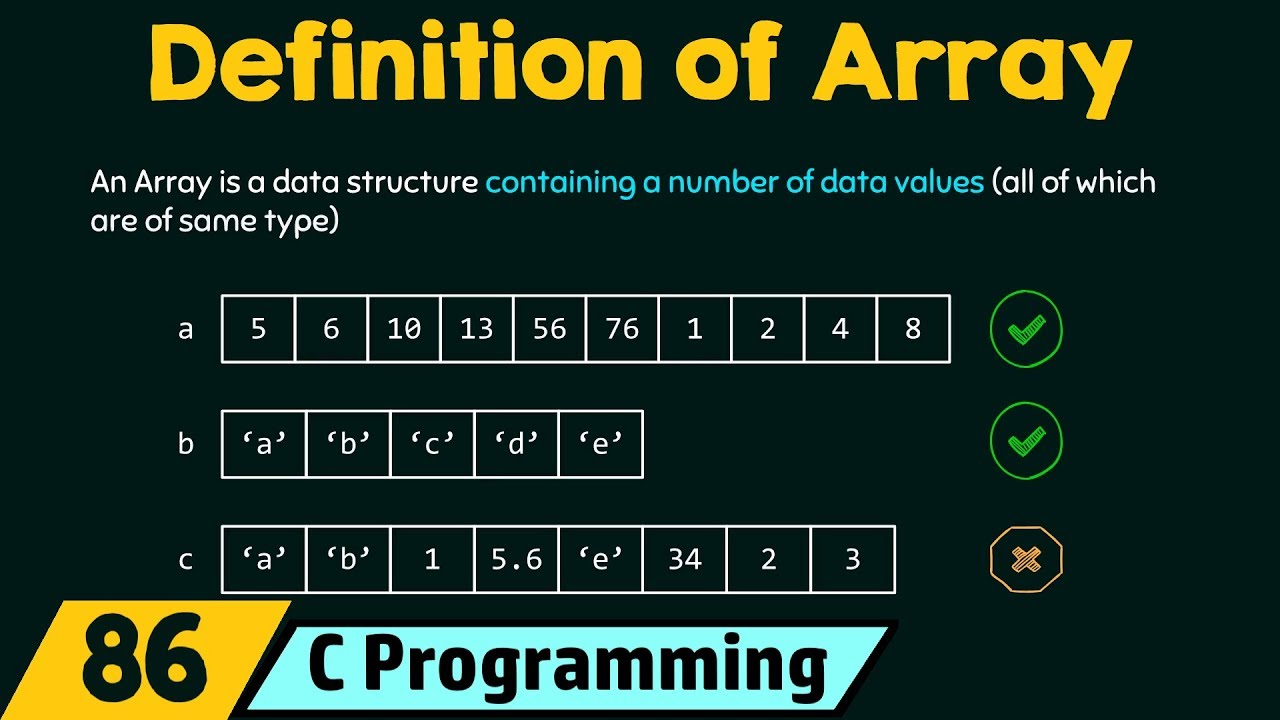

In [ ]:
# STEP 8
input_token_index = dict([(char, i) for i, char in enumerate()])
target_token_index = dict([(char, i) for i, char in enumerate()])

# STEP 9
encoder_input_data = (
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = (
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = (
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In this for loop, we are adding 1's to the places in the arrays corresponding to the distinct number of the character. The second half deals with the decoder being ahead by one timestep, which describes how the decoder is able to predict the next character in the translation. As example appears in the first graphic.

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Latent dimensionality is the size of the encoding space. 256 is a good size as it is not too small to hold enough information, and not too big that it takes too long to train.

In [ ]:
# STEP 10
latent_dim = 

Keras is setting up the layers of the neural net.

In [ ]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

After the inner workings have been set up, we are putting everything together in one model.

In [ ]:
# STEP 11
 = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# STEP 12
batch_size =   # how many samples to update the parameters of the model at a time during training
epochs = 

We are putting data into the architecture we set up, otherwise known as training. Training includes testing itself by comparing predictions to the correct answer.

Loss is the difference between the predicted value and the expected value. We minimize the loss using the optimizer, an algorithm.

We can see as the loss decreases at a slower rate, the accuracy continues to increase.

In [ ]:
model.compile(
    # STEP 13
    optimizer="rmsprop", ="categorical_crossentropy", metrics=["accuracy"]
)
# fitting = training
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

The training we just did deals exclusively with numbers and vectors. The purpose of the code below is to turn those numbers back into words.

In [ ]:
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        states_value = [h, c]
    # STEP 14
    return 

This code is taking a sequence (sentence) in English and is trying to translate to Italian.

In [ ]:
for seq_index in range(20):
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    # STEP 15
    print("Decoded sentence:", )

Chollet, F. (2017, September 29). Character-level Recurrent Sequence-to-Sequence Model. Keras. https://keras.io/examples/nlp/lstm_seq2seq/

In [ ]:
# Resources: http://www.manythings.org/anki/ ; https://keras.io/examples/nlp/lstm_seq2seq/